# Libraries

In [12]:
import csv
import os
import json
import umap
import textacy
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Articles

In [2]:
articles = []

dir = "data/biomass/"
files = os.listdir(dir)  # Set folder and files

for filename in files:

    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)

    # Parse

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Set Title

        url = data[0]["url"]  # Set URL
        if any(x in url for x in {"feeds.", "rss.", "briefing"}):
            continue  # Blacklist (Bob Dylan's case)
        # if not any(
        #     x in url
        #     for x in {
        #         "wsj.com",
        #         "usatoday.com",
        #         "nytimes.com",
        #         "latimes.com",
        #         "nypost.com",
        #         "washingtonpost.com",
        #         "chicagotribune.com",
        #         "chron.com",
        #         "nydailynews.com",
        #         "theguardian.com",
        #     }
        # ):
        #     continue  # Whitelist

        entities = data[0]["story_tags"]  # Set sentities
        if len(entities) > 100:
            continue  # Set max
        if len(entities) <= 1:
            continue  # Set min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—":
                continue  # Remove listings
            if name.startswith("geonames_"):
                continue  # Skip geotag
            if "readability" in name:
                continue  # Clean
            if "cliff_clavin_" in name:
                continue  # Clean
            if "nyt_labeller" in name:
                continue  # Clean

            name = " ".join(name.split())  # Merge multiple spaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if name.startswith("US "):
                    name = name[3:]  # Remove prefix
                if name.endswith(" Corp"):
                    name = name[:-5]  # Remive postfix
                if name.endswith(" Inc"):
                    name = name[:-4]  # Remive postfix
                if name.endswith(" LCC"):
                    name = name[:-4]  # Remive postfix
                if name[0].islower():
                    continue  # Remove lowercase
                if name[1].isupper():
                    continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name:
                    continue  # Clean
                if name[1].isupper():
                    continue  # Remove uppercase
                if name[0].islower():
                    continue  # Remove lowercase
                if len(name.split(" ")) == 1:
                    continue  # remove those with no family name
                people.append(name)

        if len(orgs) > 0 and len(subjects) > 0:
            articles.append(
                [
                    year,
                    title,
                    url,
                    list(set(subjects)),
                    list(set(orgs)),
                    list(set(people)),
                ]
            ) # Add these articles with actors only


    except:
        continue  # In case of error


articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
)  # Dataset

articles = articles.drop_duplicates(subset=["url"])  # Remove articles with the same URL

print('\n' + str(articles.shape[0]))

articles.sample(10)



18153


,year,title,url,subjects,orgs,people
13900,2019,CBD Market Could be Worth as Much as $100 Billion,https://www.prnewswire.co.uk:443/news-releases...,[finances],"[Growth, Web Holdings, Yield Growth, Barney, P...","[Kelsey Morrison, Peter Miller, Peter Horvath]"
8051,2017,\n\tWhat's in the U.S. Republicans' final tax ...,http://www.dailymail.co.uk/wires/reuters/artic...,"[law and legislation, united states economy, p...","[Senate, Reuters, Congress, House of Represent...","[Amanda Becker, Donald Trump, David Morgan, Ke..."
6676,2012,"Paul Ryan&#8217;s non-budget policy record, in...",http://www.washingtonpost.com/blogs/ezra-klein...,"[privatization, law and legislation, wages and...","[Center for Budget and Policy Priorities, Sena...","[George W Bush, Ben Cardin, Ron Paul, Paul Rya..."
4748,2018,Air quality index of Delhi 'severely' deterior...,https://www.abplive.in/india-news/air-quality-...,"[environment, air pollution]","[Central Pollution Control Board, National Gre...","[Deepak Juneja, Arvind Kejriwal, Harsh Vardhan..."
18494,2020,Carbon-Sucking Bionic Weeds Are New Front in C...,https://www.bloomberg.com/news/articles/2020-0...,"[biology and biochemistry, research, environme...","[United Nations, Stanford, Salk Institute for ...","[Joanne Chory, Rob Jackson]"
1142,2020,"After 17 years underground, vast army of cicad...",https://www.foxnews.com/science/after-17-years...,[insects],"[Virginia Tech, Magic Cicada, Fox News]","[Doug Pfeiffer, Travis Fedschun]"
5296,2015,Renewable energy developer to bring 240 jobs,http://www.chroniclelive.co.uk/news/local-news...,"[electric light and power, energy and power, l...",[Estover Energy],[Max Aitken]
1038,2015,Clean energy investment still sluggish in seco...,http://economictimes.indiatimes.com/news/inter...,"[finances, energy and power, light, electric l...","[Global clean energy, Bloomberg New Energy Fin...",[Michael Liebreich]
10300,2019,Himalayan Glaciers Lost Close to Two Feet Ice ...,https://www.news18.com/news/india/himalayan-gl...,"[weather, global warming, research]","[Columbia University, Earth Observatory, Ahona...",[Joshua Maurer]
2397,2016,Govt looks to pull off 100 GW solar capacity b...,http://www.business-standard.com/article/pti-s...,"[electric light and power, energy and power, l...",[Mumbai University],"[Piyush Goyal, Narendra Modi]"


## Entities

In [3]:
entities = np.empty((0, 12), dtype=object)

years_template = {
    2011: 0,
    2012: 0,
    2013: 0,
    2014: 0,
    2015: 0,
    2016: 0,
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
}

for index, row in articles.iterrows():

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "subject",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences

    for entity in row["orgs"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "org",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences

    for entity in row["people"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "person",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences


entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        'x',
        'y',
        'cluster',
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
14,environment,subject,7515,None,None,None,None,None,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Imperial College of London, Bhure Lal, Aishwa..."


## Normalization

In [58]:
frequency = entities_all['frequency'].to_numpy().reshape(-1, 1)
frequency
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
frequency_scaled
# df = pd.DataFrame(x_scaled)
entities_all['frequency_norm'] = frequency_scaled

entities_all.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
39040,Gustav Melin,person,1,None,None,None,None,None,"{2011: 0, 2012: 0, 2013: 0, 2014: 1, 2015: 0, ...",[http://feedproxy.google.com/~r/TheBalticTimes...,[ The future lies in biofuel tktk - The Balti...,"[Chalmers University, environment, Andris Zvei...",0.0


# Analysis

## Filter

In [59]:
n = 50 # Number of rows by type

top_subjects = entities_all.loc[entities_all['type'] == 'subject'].sort_values(by=["frequency"], ascending=False).head(n)
top_orgs = entities_all.loc[entities_all['type'] == 'org'].sort_values(by=["frequency"], ascending=False).head(n)
top_people = entities_all.loc[entities_all['type'] == 'person'].sort_values(by=["frequency"], ascending=False).head(n)

entities = pd.concat([top_subjects, top_orgs, top_people])

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
1250,genetics and heredity,subject,355,None,None,None,None,None,"{2011: 10, 2012: 10, 2013: 21, 2014: 33, 2015:...",[http://zeenews.india.com/news/sci-tech/earth-...,[Earth can sustain more terrestrial plant grow...,"[global warming, research, Evan DeLucia, envir...",0.047112


## Linear regression

In [60]:
for i, row in entities.iterrows():
    
    x = list(row['years'].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row['years'].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, 'slope'] = slope

entities.sort_values(by=["slope"], ascending=False).head(1)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
347,George Osborne,person,42,-0.521212,None,None,None,None,"{2011: 0, 2012: 3, 2013: 12, 2014: 4, 2015: 15...",[http://telegraph.feedsportal.com/c/32726/f/57...,[Business news and markets: as it happened - 2...,"[Paul Johnson, Reuters, Yorkshire, Iberia owne...",0.005456


## Colors

In [61]:
cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():
    entities.at[i, 'color'] = cmap(norm(row['slope']))

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
14,environment,subject,7515,159.557576,"(0.705673158, 0.01555616, 0.150232812, 1.0)",None,None,None,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Imperial College of London, Bhure Lal, Aishwa...",1.0


## TF-IDF

In [62]:


doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(
    # entities["cooccurrences"].tolist(), tf_type="linear", idf_type="standard"
    entities["cooccurrences"].tolist(), tf_type="linear", idf_type="smooth"
)

list(dictionary.items())[:5]


[('Imperial College of London', 26751),
 ('Bhure Lal', 6908),
 ('Aishwarya Sudhir', 1295),
 ('Indian Institute of Tropical Meteorology', 26922),
 ('Sunil Dahiya', 58069)]

## UMAP

In [63]:
reducer = umap.UMAP(
    random_state=42, n_components=2, n_neighbors=2, min_dist=0.1, metric="hellinger"
)

embedding = reducer.fit_transform(doc_term_matrix)
embedding = align_points_to_grid(embedding)

index_embedding = 0
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

entities.sample(1)


 * creating mesh with size 39 39
 * filling mesh


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
33,light,subject,5366,81.793939,"(0.705673158, 0.01555616, 0.150232812, 1.0)",-2.798026,11.775674,None,"{2011: 167, 2012: 120, 2013: 376, 2014: 523, 2...",[http://www.tampabay.com/news/business/energy/...,[Debate over energy legislation comes down to ...,"[law and legislation, Rick Scott, finances, la...",0.714001


## Clustering

In [64]:
# cluster_selection_epsilon = radius
# min_samples = number of close elements to create a set

clusterer = hdbscan.HDBSCAN(min_samples=3, cluster_selection_epsilon=0.2)

clusterer.fit(embedding)
clusters = clusterer.labels_

index_embedding = 0
for index, row in entities.iterrows():
    entities.loc[index, "cluster"] = clusters[index_embedding]
    index_embedding += 1

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
1035,fish and other marine life,subject,868,20.084848,"(0.705673158, 0.01555616, 0.150232812, 1.0)",-10.717872,6.525625,-1,"{2011: 9, 2012: 19, 2013: 45, 2014: 60, 2015: ...",[http://www.startribune.com/sports/301328271.h...,[Why stocking fish isn't the answer to walleye...,"[fishing sport, Don Pereira, Red Lake, Red Lak...",0.115385


# Plotting

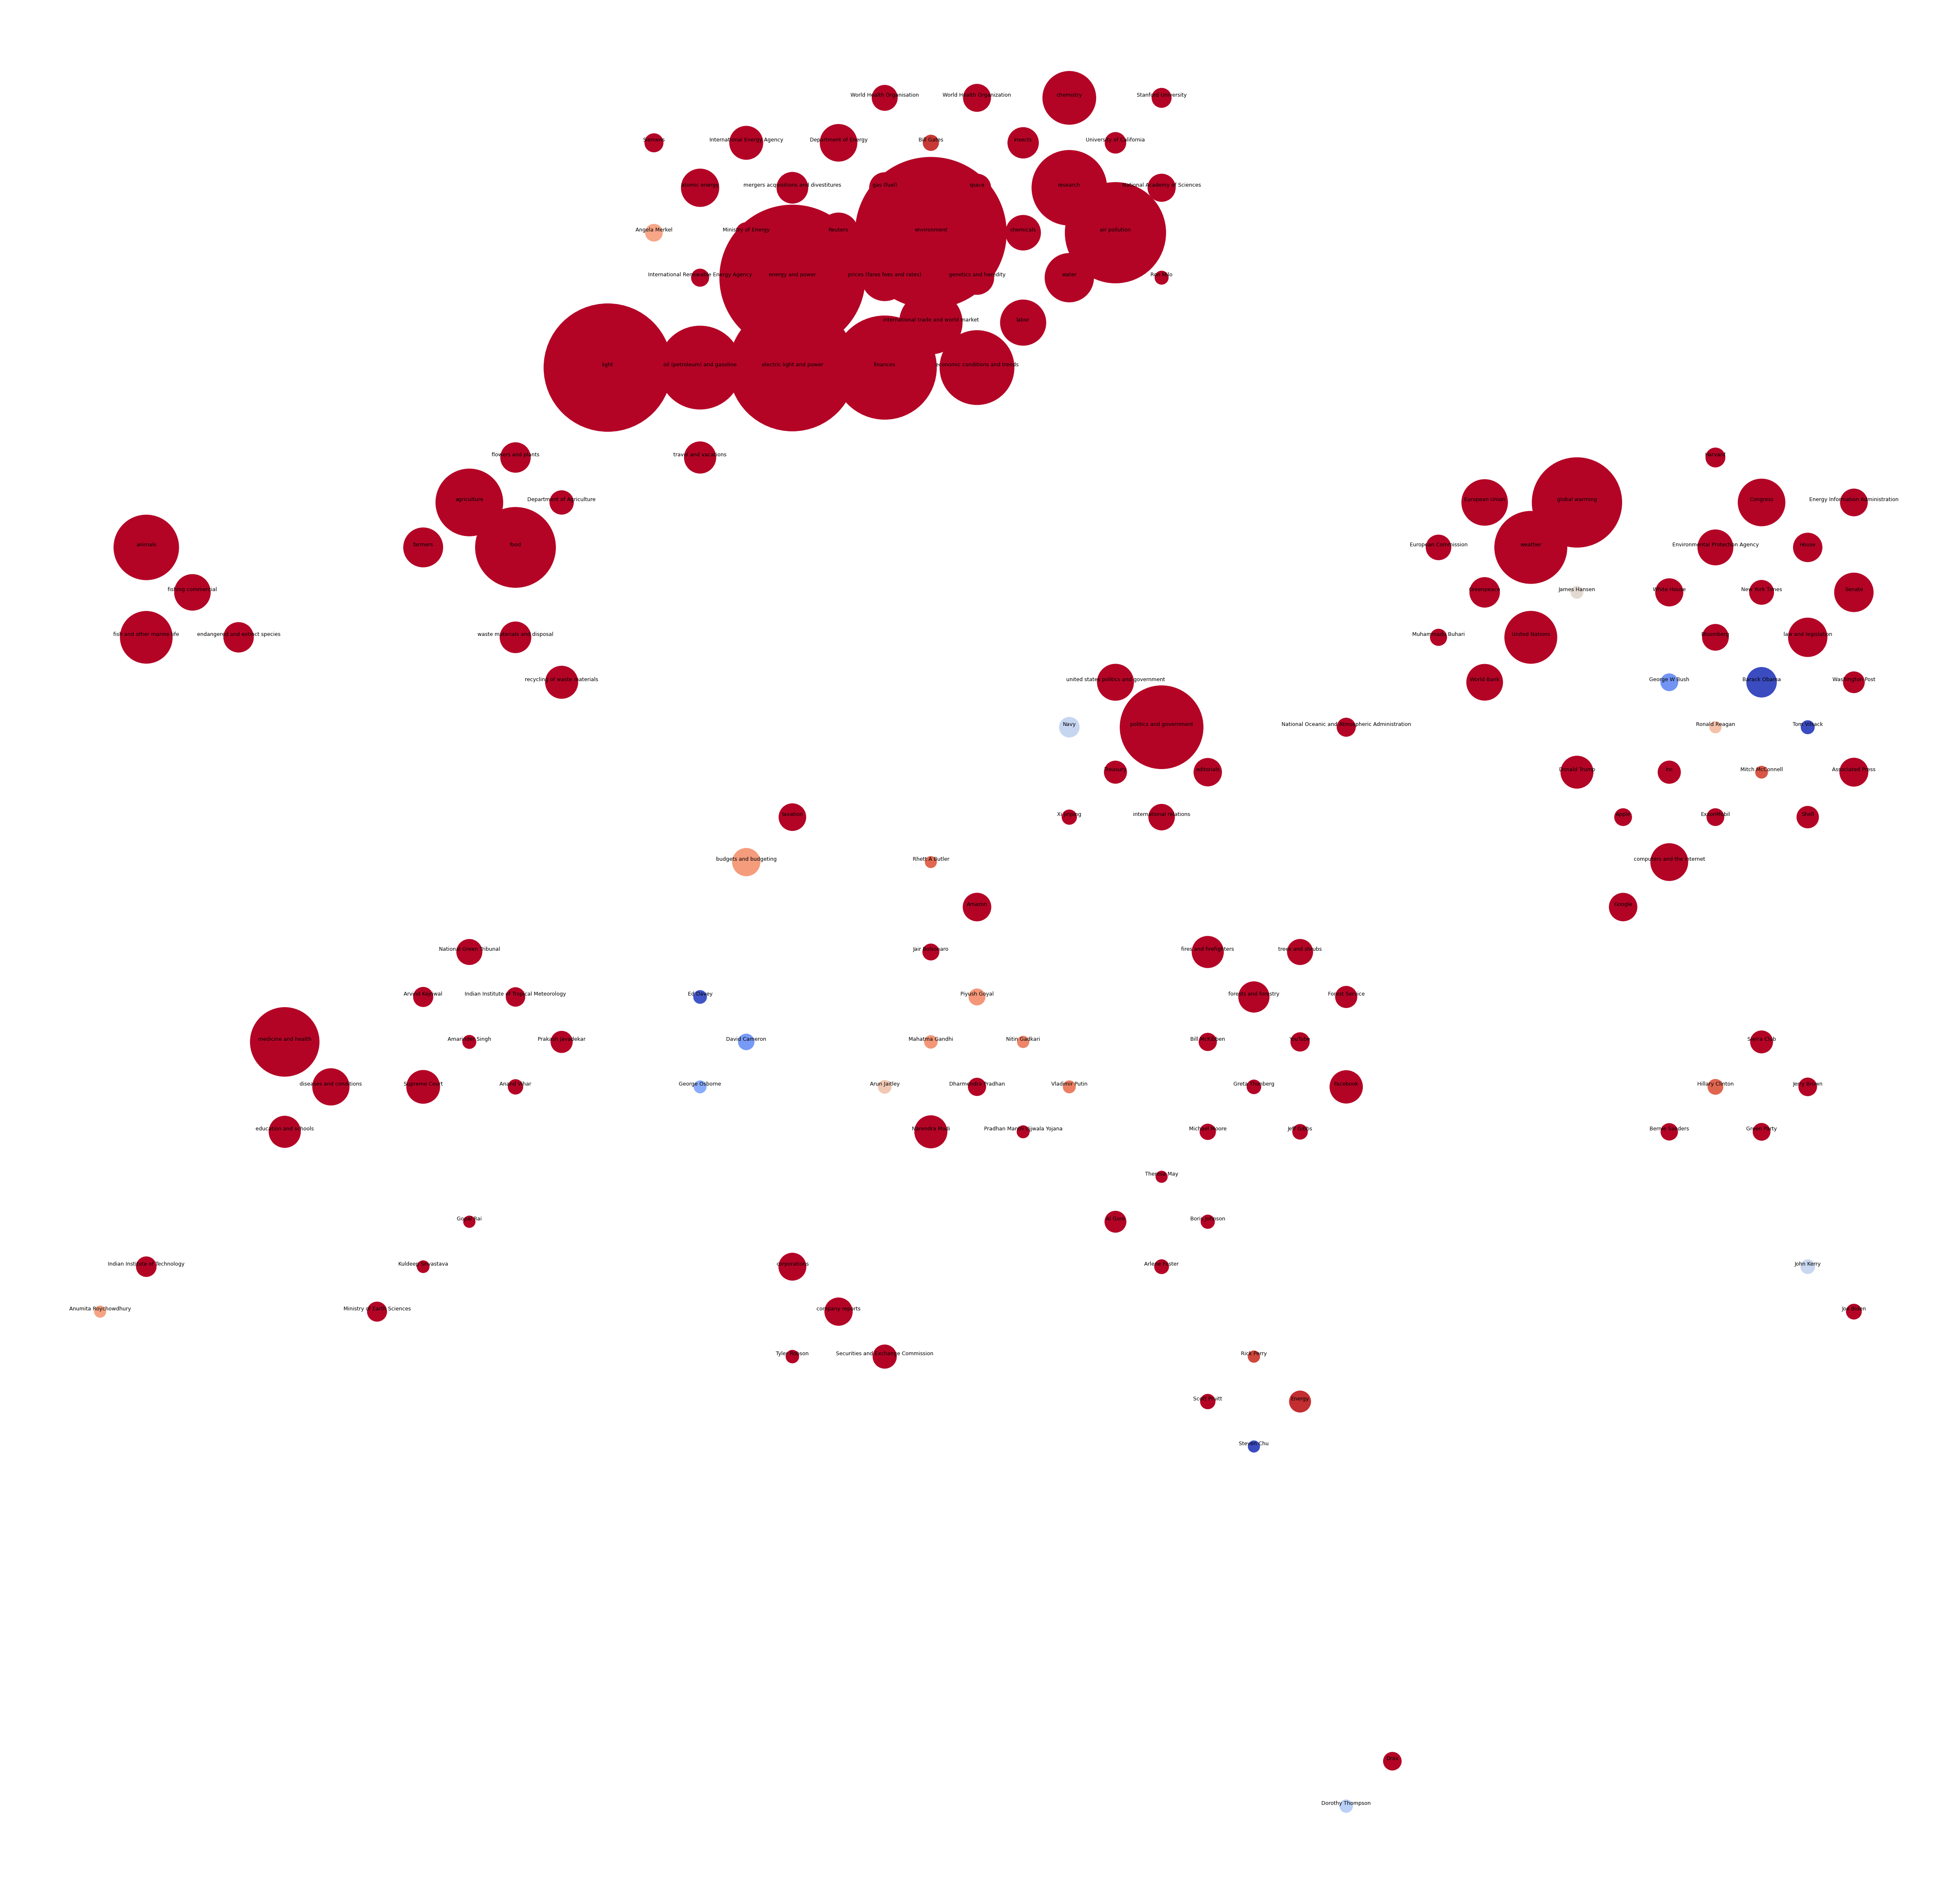

In [65]:
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(entities['x'].to_list(), entities['y'].to_list(), s=entities['frequency'].to_list(), c=entities['color'].to_list())

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row['name'], xy=(row['x'], row['y']), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


# Save

In [66]:
entities.to_csv("src/data/entities.csv", index=False)